In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for i, filename in enumerate(filenames):
        if i > 3:
            break
        print(os.path.join(dirname, filename))

/kaggle/input/audio-emotion-prediction-spectograms/train_images.csv
/kaggle/input/audio-emotion-prediction-spectograms/test_images.csv
/kaggle/input/audio-emotion-prediction-spectograms/TrainImgFiles/27326.png
/kaggle/input/audio-emotion-prediction-spectograms/TrainImgFiles/6490.png
/kaggle/input/audio-emotion-prediction-spectograms/TrainImgFiles/5511.png
/kaggle/input/audio-emotion-prediction-spectograms/TrainImgFiles/17678.png
/kaggle/input/audio-emotion-prediction-spectograms/TestImgFiles/24408.png
/kaggle/input/audio-emotion-prediction-spectograms/TestImgFiles/27985.png
/kaggle/input/audio-emotion-prediction-spectograms/TestImgFiles/45786.png
/kaggle/input/audio-emotion-prediction-spectograms/TestImgFiles/14325.png


In [2]:
train_csv = "/kaggle/input/audio-emotion-prediction-spectograms/train_images.csv"
test_csv = "/kaggle/input/audio-emotion-prediction-spectograms/test_images.csv"
TRAIN_fp = "/kaggle/input/audio-emotion-prediction-spectograms/TrainImgFiles/"
TEST_fp = "/kaggle/input/audio-emotion-prediction-spectograms/TestImgFiles/"

train_files = [fn for fn in os.listdir(TRAIN_fp) if fn.split('.')[-1] in ['png']]
test_files = [fn for fn in os.listdir(TEST_fp) if fn.split('.')[-1] in ['png']]
len(train_files), len(test_files)

(5816, 2492)

In [3]:
train_df = pd.read_csv(train_csv)
train_df.shape, train_df.columns, train_df['emotion'].value_counts()

((5816, 2),
 Index(['filename', 'emotion'], dtype='object'),
 neutral     2630
 joy          967
 surprise     640
 anger        596
 sadness      344
 fear         328
 disgust      311
 Name: emotion, dtype: int64)

In [4]:
test_df = pd.read_csv(test_csv)
test_df.shape, test_df.columns

((0, 2), Index(['filename', 'emotion'], dtype='object'))

In [5]:
from fastai.vision import *
from fastai.vision.all import *
tfms = aug_transforms(do_flip=False,flip_vert=False, max_lighting=0.1, 
                      max_zoom=1.05, max_warp=0.,max_rotate=5)

In [6]:
# RandomResizedCrop(144, min_scale=0.35)

In [7]:
dls = ImageDataLoaders.from_df(train_df, TRAIN_fp, valid_pct=0.2,
                               item_tfms=[Resize(144)],
                               batch_tfms=Normalize.from_stats(*imagenet_stats),
                              num_workers=2)
len(dls.train_ds.items), len(dls.valid_ds.items)

(4653, 1163)

In [8]:
# dls.dataset

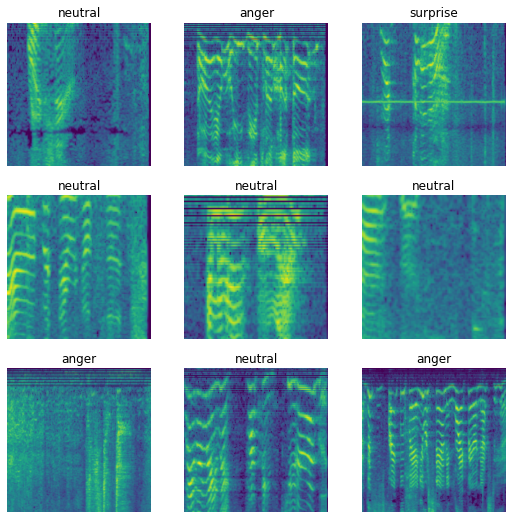

In [9]:
dls.show_batch()

In [10]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, 
                    pretrained=True, 
                    path=".",
                    model_dir="/kaggle/working/models")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [11]:
learn.fit_one_cycle(3, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,3.165754,2.220261,0.214101,04:57
1,2.942049,2.112201,0.233878,04:55
2,2.787311,2.079475,0.244196,04:54


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=6.918309736647643e-06)

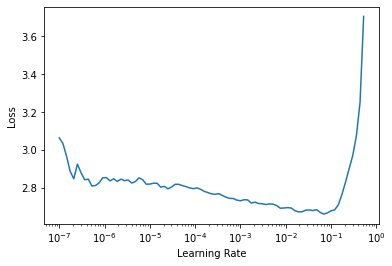

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(3, slice(1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,2.751770,2.049775,0.256234,04:53
1,2.720969,2.067347,0.251935,04:56
2,2.762715,2.057568,0.261393,04:58


In [14]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.679581,1.977556,0.282029,06:45
1,2.446298,1.788266,0.376612,06:43
2,2.115954,1.570142,0.455718,06:40
3,1.915765,1.521895,0.477214,06:41
4,1.846901,1.491815,0.490972,06:43


In [15]:
learn.freeze()
learn.fit_one_cycle(5, slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.769431,1.473762,0.505589,05:10
1,1.686099,1.589497,0.504729,05:11
2,1.568717,1.385339,0.518487,05:10
3,1.447657,1.375698,0.527945,05:08
4,1.405503,1.370284,0.522786,05:10


In [16]:
fnames = get_image_files(TEST_fp)
dl = learn.dls.test_dl(fnames, bs=64) # apply transforms
preds,  _ = learn.get_preds(dl=dl) # get prediction

In [17]:
labels = learn.dls.vocab

test_data = []
for fn, pred in zip(fnames, preds):
    idx = torch.argmax(pred).numpy()
    test_data.append([fn, labels[idx]])
    
    
preds_df = pd.DataFrame(test_data, columns=['filename', 'emotion'])
preds_df.to_csv("test_preds_v3.csv", index=False)
preds_df['emotion'].value_counts()

neutral     2039
fear         129
joy          125
disgust       98
anger         56
surprise      43
sadness        2
Name: emotion, dtype: int64

In [18]:
# test_preds = []
# fnames = get_image_files(TEST_fp)
# for fn in fnames:
#     label, idx, probas = learn.predict(fn)
#     test_preds.append(label)